In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils, generic_utils
from keras.callbacks import TensorBoard
from keras import backend as K


import tensorflow as tf
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot

import numpy as np
import scipy.io
from PIL import Image
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import preprocessing
from IPython import display
import time
import random

img_rows, img_cols, img_depth = 64, 64, 64

/home/xd/ws/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/xd/ws/tf/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
root_dir = 'dataset/'
listing = os.listdir(root_dir)
listing = sorted(listing)
maxval = 0.46
classes = {'none':0, 'left':1, 'right':2, 'click':3, 'wrist':4}
gs_class = {'left', 'right', 'click', 'wrist'}

In [44]:
X = []
y = []

width = 128 # input image shape = [width, width, 3]
delta = 24 # 24*0.625cm = 15cm
esp = 1e-6

for file in listing:
    file = root_dir + file
    data = scipy.io.loadmat(file)
#     print(file)
    # set ground truth
    gt = 'none'
    for i in gs_class:
        idx = file.find(i)
        if idx != -1:
            gt = i
            break;
        
        
    raw = data['raw']
    label = data['label']
    speed = data['speed']
    phase = data['phase']
    mask = data['mask']
    
    label_mask = (label != 0)
    label_sum = np.sum(label_mask) # total frames of labels
    
    if label_sum < 30:
        continue
    
    gs_mask = mask[label_mask[:,0], :]
    gs_window = np.sum(gs_mask, 0) / label_sum
    maxval = np.max(gs_window[width:])
    maxidx = np.argmax(gs_window[width:])
    
    if maxval < 0.3:
        continue
        
    gesture_index, b = np.nonzero(label)
    
    # set gesture region, [r_min:r_max, c_min:c_max]
    r_min, r_max = gesture_index[0], gesture_index[-1]
    r_min = max(r_min - delta, 0)
    r_max = max(r_min + width + delta, r_max)
    r_max = min(r_max, len(label))

    body_pos = maxidx + width
    c_min = body_pos - width
    c_max = min(body_pos + delta, raw.shape[1])
    
    if (r_max - r_min < width) or (c_max - c_min < width):
        print(str(c_max-c_min) + ',' + str(r_max-r_min))
        continue
    
    raw_rdm = raw[r_min:r_max, c_min:c_max]
    maxval = np.max(np.abs(raw_rdm)) + esp
    raw_rdm = raw_rdm / maxval
    
    speed_rdm = speed[r_min:r_max, c_min:c_max]
    maxval = np.max(np.abs(speed_rdm)) + esp
    speed_rdm = speed_rdm / maxval
    
    phase_rdm = phase[r_min:r_max, c_min:c_max]
    maxval = np.max(np.abs(phase_rdm)) + esp
    phase_rdm = phase_rdm / maxval
    
    raw_input = np.zeros((r_max-r_min, c_max-c_min, 3))
    raw_input[:,:,0] = raw_rdm
    raw_input[:,:,1] = speed_rdm
    raw_input[:,:,2] = phase_rdm
    X.append(raw_input)
    y.append(classes[gt])

    # generate negtive samples
    gt = 'none'
    r_min = int((gesture_index[0] + gesture_index[-1]) / 2)
    r_max = len(label)

    body_pos = maxidx + width
    c_min = body_pos - width
    c_max = min(body_pos + delta, raw.shape[1])
    
    if (r_max - r_min < width) or (c_max - c_min < width):
        print(str(c_max-c_min) + ',' + str(r_max-r_min))
        continue
    
    raw_rdm = raw[r_min:r_max, c_min:c_max]
    maxval = np.max(np.abs(raw_rdm)) + esp
    raw_rdm = raw_rdm / maxval
    
    speed_rdm = speed[r_min:r_max, c_min:c_max]
    maxval = np.max(np.abs(speed_rdm)) + esp
    speed_rdm = speed_rdm / maxval
    
    phase_rdm = phase[r_min:r_max, c_min:c_max]
    maxval = np.max(np.abs(phase_rdm)) + esp
    phase_rdm = phase_rdm / maxval
    
    raw_input = np.zeros((r_max-r_min, c_max-c_min, 3))
    raw_input[:,:,0] = raw_rdm
    raw_input[:,:,1] = speed_rdm
    raw_input[:,:,2] = phase_rdm
    
    X.append(raw_input)
    y.append(classes[gt])

152,120
152,109
152,120
152,64
152,90
152,119
152,101
152,107
152,110


In [45]:
X = np.array(X)
y = np.array(y)

In [46]:
labels = np.zeros((5))
for i in range(0, 5):
    labels[i] = np.sum(y == i)
    
# plt.hist(np.transpose(labels))
for i in range(5):
    print(labels[i])
    

396.0
197.0
117.0
44.0
47.0


In [47]:
y = np_utils.to_categorical(y, num_classes)

num_filters = [32, 32]
num_pool = [2, 4]
num_conv = [5, 3]

# X = X.astype('float32')

In [48]:
y.shape

(801, 5)

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [119]:
batch_size = 32
num_classes = 5
num_epoch = 100
train_size = len(X_train)
val_size = len(X_val)

In [110]:
K.clear_session()
model = Sequential()

model.add(Conv2D(16,
                 (3, 3),
                 input_shape=(128, 128, 3),
                 activation='relu',
                 padding='SAME'))
model.add(Conv2D(16,
                 (3, 3),
                 activation='relu',
                 padding='SAME'))
model.add(MaxPooling2D(pool_size=4))
model.add(Dropout(0.5))

model.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                 padding='SAME'))
model.add(Conv2D(16,
                 (3, 3),
                 activation='relu',
                 padding='SAME'))
model.add(MaxPooling2D(pool_size=4))
model.add(Dropout(0.5))

model.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                 padding='same'))
model.add(Conv2D(32,
                 (3, 3),
                 activation='relu',
                 padding='same'))
model.add(MaxPooling2D(pool_size=4))
model.add(Dropout(0.5))

# model.add(Conv2D(64,
#                  (3, 3),
#                  activation='relu',
#                  padding='same'))
# model.add(Conv2D(64,
#                  (3, 3),
#                  activation='relu',
#                  padding='same'))
# model.add(Conv2D(64,
#                  (3, 3),
#                  activation='relu',
#                  padding='same'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, kernel_initializer='normal'))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['mse', 'accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0         
__________

In [111]:
def generate_val_data(x, y):
    list_x = []
    list_y = []
    count = 0
    index = np.arange(len(x))
    np.random.shuffle(index)
    x = x[index]
    y = y[index]

    for i in range(len(x)):
        raw = x[i]
        sz = raw.shape
        
        label = np.argmax(y[i,:])
        dict_label = [5, 20, 30, 60, 60]
        num = dict_label[label]
        
        for j in range(num):
            r = random.randint(0, sz[0]-128)
            c = random.randint(0, sz[1]-128)
            list_x.append(raw[r:r+128,c:c+128,:])
            list_y.append(y[i])
    return np.array(list_x), np.array(list_y)

In [112]:
X_val_aug, y_val_aug = generate_val_data(X_val, y_val)

In [113]:
gt = np.zeros((5))
for i in range(len(y_val_aug)):
    label = np.argmax(y_val_aug[i,:])
    gt[label] += 1
gt

array([460., 600., 540., 600., 660.])

In [120]:
def generate_data(x, y, batch_size):
    list_x = []
    list_y = []
    count = 0
    index = np.arange(len(x))
    np.random.shuffle(index)
    x = x[index]
    y = y[index]

    while True:
        for i in range(len(x)):
            raw = x[i]
            sz = raw.shape
            
            label = np.argmax(y[i,:])
            dict_label = [100, 200, 200, 600, 600]
            num = dict_label[label]
            
            for j in range(num):
                r = random.randint(0, sz[0]-128)
                c = random.randint(0, sz[1]-128)
                list_x.append(raw[r:r+128,c:c+128,:])
                list_y.append(y[i])
                count += 1
                if count >= batch_size:
                    yield (np.array(list_x), np.array(list_y))
                    count = 0
                    list_x = []
                    list_y = []
                        
generator = generate_data(X_train, y_train, batch_size)
hist = model.fit_generator(generator=generator,
                    validation_data=(X_val_aug, y_val_aug),
                    epochs=num_epoch, 
                    steps_per_epoch=(train_size*300)//batch_size,
#                     validation_steps=val_size//batch_size,
                    callbacks=[TensorBoard(log_dir='./tmp/log')]
                   )

Epoch 1/100
6000/6000 [==============================] - 133s 22ms/step - loss: 6.4539 - mean_squared_error: 0.1905 - acc: 0.4858 - val_loss: 11.3897 - val_mean_squared_error: 0.2827 - val_acc: 0.2934
Epoch 2/100
6000/6000 [==============================] - 131s 22ms/step - loss: 6.4101 - mean_squared_error: 0.1946 - acc: 0.4541 - val_loss: 10.7191 - val_mean_squared_error: 0.2660 - val_acc: 0.3350
Epoch 3/100
6000/6000 [==============================] - 136s 23ms/step - loss: 6.3081 - mean_squared_error: 0.1918 - acc: 0.4528 - val_loss: 11.2376 - val_mean_squared_error: 0.2789 - val_acc: 0.3028
Epoch 4/100
6000/6000 [==============================] - 136s 23ms/step - loss: 6.1215 - mean_squared_error: 0.1896 - acc: 0.4500 - val_loss: 9.6709 - val_mean_squared_error: 0.2400 - val_acc: 0.4000
Epoch 5/100
6000/6000 [==============================] - 139s 23ms/step - loss: 6.3297 - mean_squared_error: 0.1884 - acc: 0.4731 - val_loss: 9.5412 - val_mean_squared_error: 0.2368 - val_acc: 0.40

Epoch 42/100
6000/6000 [==============================] - 143s 24ms/step - loss: 2.2200 - mean_squared_error: 0.1395 - acc: 0.4870 - val_loss: 1.5489 - val_mean_squared_error: 0.1561 - val_acc: 0.3490
Epoch 43/100
6000/6000 [==============================] - 141s 23ms/step - loss: 2.5245 - mean_squared_error: 0.1409 - acc: 0.5098 - val_loss: 3.5907 - val_mean_squared_error: 0.1766 - val_acc: 0.3843
Epoch 44/100
6000/6000 [==============================] - 149s 25ms/step - loss: 2.8468 - mean_squared_error: 0.1435 - acc: 0.5306 - val_loss: 2.6922 - val_mean_squared_error: 0.1764 - val_acc: 0.3594
Epoch 45/100
6000/6000 [==============================] - 142s 24ms/step - loss: 2.3538 - mean_squared_error: 0.1446 - acc: 0.4849 - val_loss: 4.2909 - val_mean_squared_error: 0.1801 - val_acc: 0.3976
Epoch 46/100
6000/6000 [==============================] - 145s 24ms/step - loss: 3.2876 - mean_squared_error: 0.1470 - acc: 0.5304 - val_loss: 2.8513 - val_mean_squared_error: 0.1693 - val_acc: 0.

Epoch 83/100
6000/6000 [==============================] - 146s 24ms/step - loss: 2.3250 - mean_squared_error: 0.1429 - acc: 0.4915 - val_loss: 1.7290 - val_mean_squared_error: 0.1700 - val_acc: 0.3140
Epoch 84/100
6000/6000 [==============================] - 151s 25ms/step - loss: 1.7666 - mean_squared_error: 0.1387 - acc: 0.4566 - val_loss: 1.5959 - val_mean_squared_error: 0.1534 - val_acc: 0.3353
Epoch 85/100
6000/6000 [==============================] - 148s 25ms/step - loss: 2.3476 - mean_squared_error: 0.1408 - acc: 0.4822 - val_loss: 1.9765 - val_mean_squared_error: 0.1643 - val_acc: 0.3385
Epoch 86/100
6000/6000 [==============================] - 148s 25ms/step - loss: 1.9971 - mean_squared_error: 0.1379 - acc: 0.4827 - val_loss: 1.6235 - val_mean_squared_error: 0.1568 - val_acc: 0.3423
Epoch 87/100
6000/6000 [==============================] - 145s 24ms/step - loss: 2.4537 - mean_squared_error: 0.1404 - acc: 0.5013 - val_loss: 2.0812 - val_mean_squared_error: 0.1697 - val_acc: 0.

In [98]:
for j in range(10):
    r = random.randint(0, 10)
    c = random.randint(0, 20)
    print(str(r) + ',' + str(c))

7,10
0,3
4,19
6,3
10,19
2,19
9,3
9,10
8,7
5,15


In [115]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

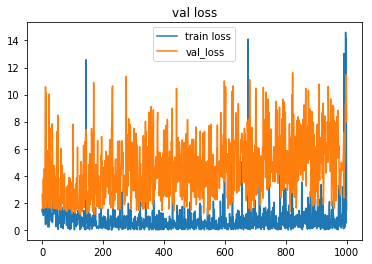

In [116]:
plt.plot(train_loss); plt.title('train loss')
plt.plot(val_loss); plt.title('val loss')
plt.legend(['train loss', 'val_loss'])

(0, 1)

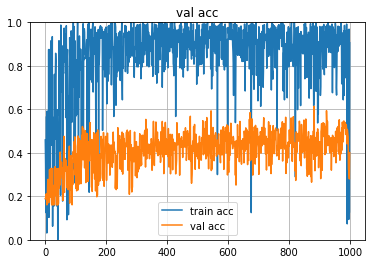

In [117]:
plt.plot(train_acc); plt.title('train acc')
plt.plot(val_acc); plt.title('val acc')
plt.legend(['train acc', 'val acc'])
plt.grid(True)
plt.ylim(0,1)

In [149]:
gestures = ['none', 'left', 'right', 'click', 'wrist']

In [15]:
np.save('X.npy', X)
np.save('y.npy', y)